# Equations of Motion in dRuBbLe
dRuBbLe includes a four degree-of-freedom (4-DOF) nonlinear dynamics simulation model to simulate the motion of the player and stool. Figure 1 is a depiction of the player in the game (left), and the corresponding dynamics model diagram (right). The following describes usage of SymPy and it's Mechanics module to derive equations of motion (EOM) in Python using a Jupyter Notebook. 



__Figure 1 - Dynamics Model Diagram__

## The TL;DR Version
This document is intentionally long and detailed to reflect the fact that it is my own personal log from learning the application of SymPy to deriving EOM, and therefore not necessarily the shortest path from point A to point B. Instead, I aim to provide detailed comments on the process, and how the dynamicist's workflow translates into Python source code. I myself plan to reference these notes as I apply this approach to real world problems in the future. That said, there is a certain value to finding the minimum amount of code necessary to reach the desired result. To that end, I present the following: 

In [1]:
# Import required tools, and set up typesetting
from sympy import *
from sympy.physics.mechanics import *
from IPython.display import display, Latex
mechanics_printing()

# Define generalized coordinates, and derivatives w.r.t. time
x, y, l, th = dynamicsymbols('x y l θ')
dxdt, dydt, dldt, dthdt = dynamicsymbols('x y l θ', 1)
generalized_coords = q = Matrix([x, y, l, th])
x0, y0, l0, th0 = symbols('x_0 y_0 l_0 θ_0')
q0 = Matrix([x0, y0, l0, th0])

# Define constants
mp, ms, d, grav, t = symbols('m_p m_s d g t')
Ky, Kl, Kt = symbols('K_y K_l K_θ')
Cx, Cy, Cl, Cth = symbols('C_x C_y C_l C_θ')
Qx, Qy, Ql, Qth = symbols('Q_x Q_y Q_l Q_θ')

# Define frames
R = ReferenceFrame('R')
E = R.orientnew('E', 'Axis', [th, R.z])

# Define points (O: origin, 'p': player center of mass, 's': stool center of mass)
origin = Point('O')
origin.set_vel(R, 0)
player_cm = Point('p')
player_cm.set_pos(origin, x * R.x + y * R.y)
player_cm.set_vel(R, player_cm.pos_from(origin).dt(R))
stool_cm = Point('s')
stool_cm.set_pos(player_cm, d * R.y + l * E.y)
stool_cm.set_vel(R, stool_cm.pos_from(origin).dt(R))

# Define bodies
player = Particle('player', player_cm, mp)
stool = Particle('stool', stool_cm, ms)

# Define loads
loads = [(player_cm,mp*grav*R.y - Ky*(y-y0)*R.y + Kl*(l-l0)*E.y 
          - Cx*dxdt*R.x - Cy*dydt*R.y + Cl*dldt*E.y + Qx*R.x + Qy*R.y - Ql*E.y), 
         (stool_cm, ms*grav*R.y - Kl*(l-l0)*E.y - Cl*dldt*E.y + Ql*E.y),
         (R, Kt*th*E.z + Cth*dthdt*E.z - Qth*E.z),                  
         (E, -Kt*th*E.z - Cth*dthdt*E.z + Qth*E.z)]                  

# Apply Lagrange's method
L = Lagrangian(R, player, stool)
LM = LagrangesMethod(L, q, forcelist=loads, frame=R)
display(simplify(LM.form_lagranges_equations()))

⎡                                                   2                         
⎢                Cₓ⋅ẋ - Qₓ + mₚ⋅ẍ + mₛ⋅l⋅sin(θ)⋅θ̇  - mₛ⋅l⋅cos(θ)⋅θ̈ - mₛ⋅si
⎢                                                                             
⎢                                                                             
⎢C_y⋅ẏ - K_y⋅y₀ + K_y⋅y - Q_y - g⋅mₚ - g⋅mₛ + mₚ⋅ÿ - mₛ⋅l⋅sin(θ)⋅θ̈ - mₛ⋅l⋅c
⎢                                                                             
⎢                                                                     2       
⎢                    Cₗ⋅l̇ - Kₗ⋅l₀ + Kₗ⋅l - Qₗ - g⋅mₛ⋅cos(θ) - mₛ⋅l⋅θ̇  - mₛ⋅s
⎢                                                                             
⎢                                                           2                 
⎣                C_θ⋅θ̇ + K_θ⋅θ - Q_θ + g⋅mₛ⋅l⋅sin(θ) + mₛ⋅l ⋅θ̈ - mₛ⋅l⋅sin(θ)

                                                    ⎤
n(θ)⋅l̈ - 2⋅mₛ⋅cos(θ)⋅l̇⋅θ̇ + mₛ⋅ẍ                 ⎥
                      

## Table of Contents
* [Setup](#setup)
* [Kinematics](#kinematics)
* [Lagrange's Method](#lagrange)
* [Built-in Methods](#built-in)
* [Code Generation](#codegen)

## Setup <a class="anchor" id="setup"></a>
First we import the NumPy and SymPy mechanics modules in Python. NumPy provides an extensive set of numerical analysis funtions, while SymPy is a symbolic coding environment with the mechanics module standardizing various kinematic transformations and EOM generation. The IPython display modules are imported to generate typeset equations suitable for document publication. Turning on `mechanics_printing()` will generate more compact typeset equations, where $\frac{\partial x}{\partial t}$ will be written $\dot{x}$, for example.

In [2]:
import numpy as np
from sympy import *
from sympy.physics.mechanics import *
from IPython.display import display, Latex
mechanics_printing()

It is desirable to display equations showing the symbol representation equated to the calculated result, using $\LaTeX$ typesetting. We create a user defined function to simplify this display. Typically the first argument will be a string, and the second will be a SymPy object, though there is some flexibility in order. An equals sign will be placed between the two when typesetting using the `display` and `Latex` functions. If additional arguments are provided, they will also be equated to the first arguments.

In [3]:
def dtex(*args):
    tex = ''
    for arg in args:  # Loop all arguments
        if type(arg) is str:
            tex += '$' + arg + '$ $\, = \,$ '  # Handle string arguments
        else:
            tex += arg._repr_latex_() + ' $\, = \,$ '  # Handle SymPy arguments
    
    tex = tex[:-10]  # Trim off the last equals sign
    display(Latex(tex))    

### Generalized Coordinates
To begin the dynamics model formulation, we first define the generalized coordinates. The player is defined as a point mass located at point $p$, with positions $(x, y)$ defined relative to the origin in the horizontal and vertical directions, respectively. The stool is also defined as a point mass located at point $s$, which is translated and rotated relative to the player with a transformation requiring an arm extension length $l$, and stool tilt angle $θ$. These four variables form the generalized coordinate vector $\mathbf{q}$. 

The SymPy Mechanics `dynamicsymbols` function is used to define these as symbolic variables that are time-varying. Notably, the left hand side of the equation are the variables to be used in the source code, where `th` is used in place of $θ$. When typing code that references the tilt angle, `th` will be used, whereas when the `display` function is called to typeset the equation, the more visually appealing $θ$ is used, as seen below. Also note that the display adds the $(t)$ to each variable, indicating it is time-varying. The chained assignment operators (i.e. `a = b = c`) are used such that in the source code the variables `generalized_coords` and `q` can be used interchangeably.

In [4]:
x, y, l, th = dynamicsymbols('x y l θ')
generalized_coords = q = Matrix([x, y, l, th])
dtex('\mathbf{q}', q)

<IPython.core.display.Latex object>

We will also need the derivatives of these coordinates with respect to time, which are obtained by calling the `dynamicsymbols` function with the second argument `1` indicating the first derivative, and `2` indicating the second derivative.

In [5]:
dxdt, dydt, dldt, dthdt = dynamicsymbols('x y l θ', 1)
ddt_generalized_coords = dqdt = Matrix([dxdt, dydt, dldt, dthdt])
d2xdt2, d2ydt2, d2ldt2, d2thdt2 = dynamicsymbols('x y l θ', 2)
d2dt2_generalized_coords = d2qdt2 = Matrix([d2xdt2, d2ydt2, d2ldt2, d2thdt2])
dtex('\dot{\mathbf{q}}', dqdt)
dtex('\ddot{\mathbf{q}}', d2qdt2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Initial values for the generalized coordinates are represented by a subscript $0$, where $\boldsymbol{q}_0 = (x_0, y_0, l_0, θ_0)^T$. In SymPy, these are defined using a call to the `symbols` function, which declares them as constants. As before, a slight variation is used for the variable representation in the source code versus in typesetting, where for the latter the underscore is used to ensure that these are typeset as a subscript.

In [6]:
x0, y0, l0, th0 = symbols('x_0 y_0 l_0 θ_0')
q0 = Matrix([x0, y0, l0, th0])
dtex('\mathbf{q}_0', q0)

<IPython.core.display.Latex object>

### Constants
Next we define the constants, including masses $m_p$ and $m_s$ of the player and stool, an offset distance $d$ between the player center of mass and the point about which the stool rotates, the gravitational constant $g$ (represented by `grav` in source code). 

In [7]:
mp, ms, d, grav, t = symbols('m_p m_s d g t')

The spring coefficients $K_y$, $K_l$, and $K_θ$ introduce generalized forces into the system proportional to the subscripted coordinate minus its initial value. 

In [8]:
Ky, Kl, Kt = symbols('K_y K_l K_θ')

Likewise, the damping constants $C_x$, $C_y$, $C_l$, and $C_θ$ induce generalized forces proportional to derivatives with respect to time of the generalized coordinates.

In [9]:
Cx, Cy, Cl, Cth = symbols('C_x C_y C_l C_θ')
generalized_damping_forces = Qdamping = Matrix([- Cx * dxdt, - Cy * dydt, - Cl * dldt, - Cth * dthdt])
dtex('\mathbf{Q}_{damping}', Qdamping)

<IPython.core.display.Latex object>

The generalized input forces $Q_x$, $Q_y$, $Q_l$, and $Q_θ$ represent the control variables, from either player inputs or the computer control logic algorithm.

In [10]:
Qx, Qy, Ql, Qth = symbols('Q_x Q_y Q_l Q_θ')
generalized_input_forces = Qinput = Matrix([Qx, Qy, Ql, Qth])
dtex('\mathbf{Q}_{input}', Qinput)

<IPython.core.display.Latex object>

## Kinematics <a class="anchor" id="kinematics"></a>
The inertial reference frame is designated as `R`. The default convention in SymPy Mechanics is to represent the reference frame `R` using the unit vectors $\mathbf{\hat{r}}_x$, $\mathbf{\hat{r}}_y$, and $\mathbf{\hat{r}}_z$, however, these default symbols are replaced with unit vectors $\mathbf{\hat{i}}$, $\mathbf{\hat{j}}$, and $\mathbf{\hat{k}}$ for typesetting purposes, where $\mathbf{\hat{i}}$ is horizontal to the right side of the screen, $\mathbf{\hat{j}}$ is vertical and upward, and $\mathbf{\hat{k}}$ is out of the page. It is understood these are spatially fixed such that  $\partial\mathbf{\hat{i}} / \partial t = \partial\mathbf{\hat{j}} / \partial t = \partial\mathbf{\hat{k}} / \partial t = 0$. The stool frame is designated as `E`, with the default unit vectors provided by SymPy Mechanics of $\mathbf{\hat{e}}_x$, $\mathbf{\hat{e}}_y$, and $\mathbf{\hat{e}}_z$, which are oriented relative to the reference frame `R` by a rotation of $\theta$ about the $\mathbf{\hat{k}}$ axis, where $\mathbf{\hat{k}}$ is accessed in the source code as `R.z`. The direction cosine matrix (DCM) that transforms from the `R` to the `E` frame is given by $\mathbf{R}_e$.

In [11]:
R = ReferenceFrame('R')
R.pretty_vecs = ['i', 'j', 'k']
R.latex_vecs = ['\\mathbf{\\hat{i}}', '\\mathbf{\\hat{j}}', '\\mathbf{\\hat{k}}']
E = ReferenceFrame('E')
E.orient(R, 'Axis', [th, R.z])
Re = E.dcm(R)
dtex('\mathbf{R}_e', Re)

<IPython.core.display.Latex object>

The origin is defined as a `Point` designated `O`, and its velocity is set to zero using the `.set_vel()` method. The ensuing points of interest will be defined relative to the origin.

In [12]:
origin = Point('O')
origin.set_vel(R, 0)

### Positions
The player's center of mass is located at the point `p`, which has the position vector $\mathbf{r}_p$ given by the generalized coordinates $x$ and $y$, measured relative to the origin in the `R` frame. The `.set_pos()` method is used to define this position, with the source code `R.x` and `R.y` to access the unit vectors $\mathbf{\hat{i}}$ and $\mathbf{\hat{j}}$, respectively.

In [13]:
player_cm = Point('p')
player_cm.set_pos(origin, x * R.x + y * R.y)
rp = player_cm.pos_from(origin)
dtex('\mathbf{r}_p', rp)

<IPython.core.display.Latex object>

The stool center of mass is located at the point `s`, which has the position vector $\mathbf{r}_s$, which is offset vertically from `p` by a constant distance $d$ in the $\mathbf{\hat{j}}$ direction, and by $l(t)$ in the $\mathbf{\hat{e}}_y$ direction (accessed as `E.y` in the source code). To view the equivalent positions in the inertial coordinates, we use the `.express()` or `.to_matrix()` methods, each taking the desired frame `R` as an argument.

In [14]:
stool_cm = Point('s')
stool_cm.set_pos(player_cm, d * R.y + l * E.y)
rs = stool_cm.pos_from(origin)
dtex('\mathbf{r}_s', rs, rs.express(R), rs.to_matrix(R))

<IPython.core.display.Latex object>

### Velocities
The velocity of the point `p`, given by $\mathbf{v}_p$, is calculated by taking its time derivative evaluated in the frame `R`.

In [15]:
vp = rp.dt(R) 
player_cm.set_vel(R, vp)
dtex('\mathbf{v}_p', vp)

<IPython.core.display.Latex object>

Similarly, the velocity of the point `s`, given by $\mathbf{v}_s$ is calculated in the same way. By default, the velocity of `s` relative to `p` is given in the rotated stool frame, with a tangential term $l\dot{\theta}\hat{\mathbf{e}}_x$ and radial term $\dot{l}\hat{\mathbf{e}}_y$. The `.express()` method is used to give the equivalent velocity in the inertial $\hat{\mathbf{i}}$ and $\hat{\mathbf{j}}$ coordinates.

In [16]:
vs = rs.dt(R) 
stool_cm.set_vel(R, vs)
dtex('\mathbf{v}_s', vs, vs.express(R))

<IPython.core.display.Latex object>

## Lagrange's Method <a class="anchor" id="lagrange"></a>
First the equations will be derived using Lagrange's method, without utilizing the Mechanics module (except for using the position and velocity vectors already defined). 
### Energy
The kinetic energy, $T = \frac{1}{2} m_p \mathbf{v}_p \cdot \mathbf{v}_p + \frac{1}{2} m_s \mathbf{v}_s \cdot \mathbf{v}_s$, is calculated where $m_p$ and $m_s$ are the point masses assigned to the player and stool, and $(\,\cdot\,)$ represents the dot product.

<IPython.core.display.Latex object>

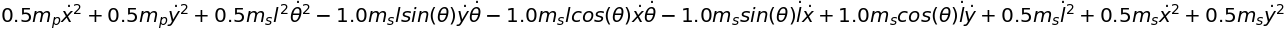

In [17]:
T = simplify(0.5 * mp * dot(vp, vp) + 0.5 * ms * dot(vs, vs))
dtex('T = ')
display(T)

The potential energy $V$ is the sum of the gravitational potential $(m_p \mathbf{r}_p + m_s \mathbf{r_s}) \cdot g \hat{\mathbf{j}}$ plus spring potential $K_y (y - y_0)^2$, $K_l (l - l_0)^2$, and $K_\theta \theta^2$. 

In [18]:
V = dot(mp * rp + ms * rs, grav * R.y) + 0.5 * ( Ky * (y - y0)**2 + Kl * (l - l0)**2 + Kt * th**2 )
V = simplify(V)
dtex('V', V)

<IPython.core.display.Latex object>

The Lagrangian $L = T - V$

<IPython.core.display.Latex object>

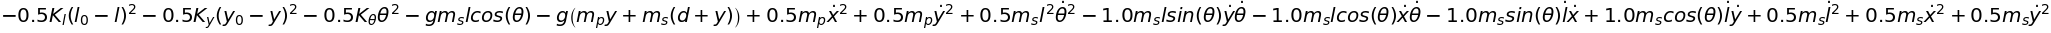

In [19]:
L = T - V
dtex('L', 'T - V = ')
display(L)

### Equations of Motion
EOM are calculated using Lagrange's method where $\frac{d}{dt} \left( \frac{\partial L}{\partial\dot{\mathbf{q}}}\right) - \frac{\partial L}{\partial \mathbf{q}} = \mathbf{Q}_{damping} + \mathbf{Q}_{input}$, or equivalently $\frac{d}{dt} \left( \frac{\partial L}{\partial\dot{\mathbf{q}}}\right) - \frac{\partial L}{\partial \mathbf{q}} - \mathbf{Q}_{damping} - \mathbf{Q}_{input} = \mathbf{0}$, noting that the convention in SymPy is that whenever a system of equations is presented it is assumed equal to zero.

<IPython.core.display.Latex object>

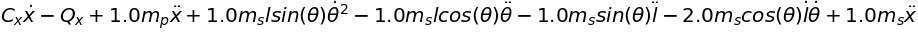

<IPython.core.display.Latex object>

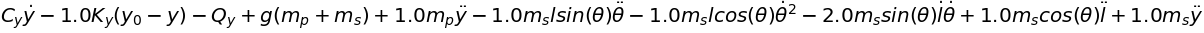

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [20]:
# Initialize the eom matrix
eom = Matrix([None, None, None, None])

for k in range(4):
    # Apply Lagrange's method
    tmp = diff(diff(L, dqdt[k]), t) - diff(L, q[k]) - Qdamping[k] - Qinput[k]
    
    # Simplify and insert into eom matrix
    eom[k] = simplify(tmp)

    # Display result
    display(Latex('EOM for ' + q[k]._repr_latex_() + ' is : '), eom[k])


### Mass Matrix
The mass matrix is calculated by taking the derivative of each EOM with respect to each acceleration term. The primary terms are found along the diagonal, the first three reflect the player and stool mass for the translational DOFs, and the fourth represents the effective moment of inertia for the stool mass eccentricity from its rotation center. The mass matrix inverse is also calculated.

In [21]:
M = Matrix([[diff(eom[j], d2qdt2[k]) for j in range(4)] for k in range(4)])
       
dtex('\mathbf{M}', M)        
dtex('\mathbf{M}^{-1}', simplify(M.inv()))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Integrable Form
Next solve the EOM for the accelerations, $\partial^2 \boldsymbol{q} / \partial t^2$, using the SymPy `solve` function. This returns a dictionary where the keys are the symbolic variables for $\partial^2 \mathbf{q} / \partial t^2$. The loop simplifies the solution equations, and places them into a list that is given in the original order of `eom`. 

<IPython.core.display.Latex object>

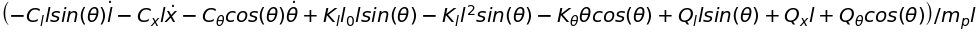

<IPython.core.display.Latex object>

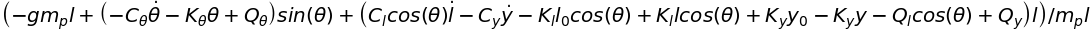

<IPython.core.display.Latex object>

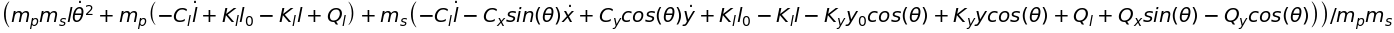

<IPython.core.display.Latex object>

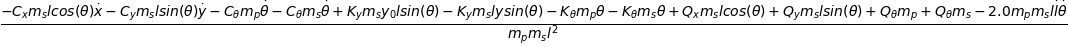

In [22]:
# Solve for the accelerations
eom_solved = solve(eom, d2qdt2)

# Insert the equation from the eom_solved dictionary indexed using d2qdt2
eoms = Matrix([simplify(eom_solved[d2qdt2[k]]) for k in range(4)])

for k in range(4):
    # Display the equation
    print(' ')
    display(Latex(d2qdt2[k]._repr_latex_() + '$\, = \,$'), eoms[k])

## Built-in Methods <a class="anchor" id="built-in"></a>
Now the EOM are derived using Kane's method as-implemented in Sympy Mechanics. 
### Generalized Speeds
To facilitate EOM generation using Kane's method, we define a set of generalized speeds. In this case, we will use substition variables $u = \frac{\partial x}{\partial t}$, $v = \frac{\partial y}{\partial t}$, $w = \frac{\partial l}{\partial t}$, and $ω = \frac{\partial θ}{\partial t}$.

In [23]:
u, v, w, omeg = dynamicsymbols('u v w ω')
generalized_speeds = s = Matrix([u, v, w, omeg])
dudt, dvdt, dwdt, domegdt = dynamicsymbols('u v w ω', 1)
ddt_generalized_speeds = dsdt = Matrix([dudt, dvdt, dwdt, domegdt])
dtex('\mathbf{s}', generalized_speeds)

<IPython.core.display.Latex object>

A kinematic equation will be used in Kane's method to define the equality $\mathbf{s} = \dot{\mathbf{q}}$, equivalently $\mathbf{s} - \dot{\mathbf{q}} = \mathbf{0}$. The latter convention is commonly used by the SymPy solvers, where a matrix representing a system of equations will be assumed to be in equilibrium, or in other words equal to a matrix of zeros with the same dimension.

In [24]:
kinematic_equation = s - dqdt
display(kinematic_equation)

⎡u - ẋ⎤
⎢      ⎥
⎢v - ẏ⎥
⎢      ⎥
⎢w - l̇⎥
⎢      ⎥
⎣ω - θ̇⎦

### Bodies
The player and stool are both defined as `Particle` objects, in other words point masses. The first argument to the class is the name of the particle, second article is a `Point` object corresponding to the centers of mass, and third object is the mass, in this case symbolic. These are added to the `bodies` list.

In [25]:
player = Particle('player', player_cm, mp)
stool = Particle('stool', stool_cm, ms)
bodies = [player, stool]

### Loads
The bodies are acted on by various forces and moments, including from gravity, spring extension, damping, and player input. For each constituent load, the force or moment terms are placed in a tuple, where the first term in said tuple is the load vector acting on the player, and the second is the load vector acting on the stool. The `loads` variable is a list of tuples, where in each tuple the first entry is either a `Point` (for forces) or `ReferenceFrame` (for moments) object, and the second entry in the tuple is the net force or moment vector acting on said object. 

<IPython.core.display.Latex object>

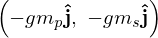

<IPython.core.display.Latex object>

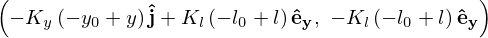

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

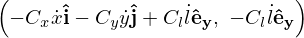

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

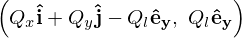

<IPython.core.display.Latex object>

In [26]:
gravitational_forces = Fg = - mp * grav * R.y, -ms * grav * R.y
spring_forces = Fk = - Ky * (y - y0) * R.y + Kl * (l - l0) * E.y, - Kl * (l - l0) * E.y
spring_moments = Mk = Kt * th * E.z, - Kt * th * E.z
damping_forces = Fd = - Cx * dxdt * R.x - Cy * dydt * R.y + Cl * dldt * E.y, - Cl * dldt * E.y
damping_moments = Md = Cth * dthdt * E.z, - Cth * dthdt * E.z
input_forces = Fi = Qx * R.x + Qy * R.y - Ql * E.y, Ql * E.y
input_moments = Mi = - Qth * E.z, Qth * E.z
loads = [(player_cm, Fg[0] + Fk[0] + Fd[0] + Fi[0]),  # Forces on the player
         (stool_cm, Fg[1] + Fk[1] + Fd[1] + Fi[1]),   # Forces on the stool
         (R, Mk[0] + Md[0] + Mi[0]),                  # Moments on the player, R-frame
         (E, Mk[1] + Md[1] + Mi[1])]                  # Moments on the stool, E-frame
display(Latex('Gravitational Forces : '), Fg)
display(Latex('Spring Forces : '), Fk)
display(Latex('Spring Moments : '), Mk)
display(Latex('Damping Forces : '), Fd)
display(Latex('Damping Moments : '), Md)
display(Latex('Input Forces : '), Fi)
display(Latex('Input Moments : '), Mi)

### Kane's Equations
The built-in Kane's Method class is used to derive EOM. When initiating the object, the first argument is the reference frame `R`, then the keyword arguments `q_ind` for the generalized coordinate vector, `u_ind` for the generalized speed vector, and `kd_eqs` for the kinematic equations relating the two. The `.kanes_equations()` method is called for the defined bodies and loads, which yields $\mathbf{F}_r$, which are the active forces, and $\mathbf{F}_r^*$, which are the inertial forces, respectively. The class also automates the generation of the mass matrix $\mathbf{M}$ and forcing vector $\mathbf{F}$, which can be used to shorten the system of equations to $\mathbf{M}\dot{\mathbf{s}} = \mathbf{F}$.

In [27]:
kane = KanesMethod(R, q_ind=q, u_ind=s, kd_eqs=kinematic_equation)
fr, frstar = kane.kanes_equations(bodies, loads)
display(Latex('$\mathbf{F}_r = $'), fr)
display(Latex('$\mathbf{F}_r^* = $'), frstar)
display(Latex('$\mathbf{M} = $'), kane.mass_matrix)
display(Latex('$\mathbf{F} = $'), kane.forcing)

<IPython.core.display.Latex object>

⎡                -Cₓ⋅ẋ + Qₓ - (-Cₗ⋅l̇ - Kₗ⋅(-l₀ + l) + Qₗ)⋅sin(θ) - (Cₗ⋅l̇ + 
⎢                                                                             
⎢-C_y⋅ẏ - K_y⋅(-y₀ + y) + Q_y - g⋅mₚ - g⋅mₛ + (-Cₗ⋅l̇ - Kₗ⋅(-l₀ + l) + Qₗ)⋅co
⎢                                                                             
⎢                                       -Cₗ⋅l̇ - Kₗ⋅(-l₀ + l) + Qₗ - g⋅mₛ⋅cos(
⎢                                                                             
⎣                                        -C_θ⋅θ̇ - K_θ⋅θ + Q_θ + g⋅mₛ⋅l⋅sin(θ)

Kₗ⋅(-l₀ + l) - Qₗ)⋅sin(θ)                ⎤
                                         ⎥
s(θ) + (Cₗ⋅l̇ + Kₗ⋅(-l₀ + l) - Qₗ)⋅cos(θ)⎥
                                         ⎥
θ)                                       ⎥
                                         ⎥
                                         ⎦

<IPython.core.display.Latex object>

⎡        2                                                                    
⎢- mₛ⋅l⋅ω ⋅sin(θ) + mₛ⋅l⋅cos(θ)⋅ω̇ + 2⋅mₛ⋅w⋅ω⋅cos(θ) + mₛ⋅sin(θ)⋅ẇ - (mₚ + mₛ
⎢                                                                             
⎢       2                                                                     
⎢ mₛ⋅l⋅ω ⋅cos(θ) + mₛ⋅l⋅sin(θ)⋅ω̇ + 2⋅mₛ⋅w⋅ω⋅sin(θ) - mₛ⋅cos(θ)⋅ẇ - (mₚ + mₛ)
⎢                                                                             
⎢                        2                                                    
⎢                  mₛ⋅l⋅ω  + mₛ⋅sin(θ)⋅u̇ - mₛ⋅cos(θ)⋅v̇ - mₛ⋅ẇ              
⎢                                                                             
⎢                  2                                                          
⎣            - mₛ⋅l ⋅ω̇ - 2⋅mₛ⋅l⋅w⋅ω + mₛ⋅l⋅sin(θ)⋅v̇ + mₛ⋅l⋅cos(θ)⋅u̇        

    ⎤
)⋅u̇⎥
    ⎥
    ⎥
⋅v̇ ⎥
    ⎥
    ⎥
    ⎥
    ⎥
    ⎥
    ⎦

<IPython.core.display.Latex object>

⎡  mₚ + mₛ          0        -mₛ⋅sin(θ)  -mₛ⋅l⋅cos(θ)⎤
⎢                                                    ⎥
⎢     0          mₚ + mₛ     mₛ⋅cos(θ)   -mₛ⋅l⋅sin(θ)⎥
⎢                                                    ⎥
⎢ -mₛ⋅sin(θ)    mₛ⋅cos(θ)        mₛ           0      ⎥
⎢                                                    ⎥
⎢                                               2    ⎥
⎣-mₛ⋅l⋅cos(θ)  -mₛ⋅l⋅sin(θ)      0          mₛ⋅l     ⎦

<IPython.core.display.Latex object>

⎡                                    2                                        
⎢                -Cₓ⋅ẋ + Qₓ - mₛ⋅l⋅ω ⋅sin(θ) + 2⋅mₛ⋅w⋅ω⋅cos(θ) - (-Cₗ⋅l̇ - Kₗ
⎢                                                                             
⎢                                                    2                        
⎢-C_y⋅ẏ - K_y⋅(-y₀ + y) + Q_y - g⋅mₚ - g⋅mₛ + mₛ⋅l⋅ω ⋅cos(θ) + 2⋅mₛ⋅w⋅ω⋅sin(θ
⎢                                                                             
⎢                                                                             
⎢                                                   -Cₗ⋅l̇ - Kₗ⋅(-l₀ + l) + Qₗ
⎢                                                                             
⎣                                                   -C_θ⋅θ̇ - K_θ⋅θ + Q_θ + g⋅

                                                                            ⎤
⋅(-l₀ + l) + Qₗ)⋅sin(θ) - (Cₗ⋅l̇ + Kₗ⋅(-l₀ + l) - Qₗ)⋅sin(θ)                ⎥
                                                     

### Integrable form
As with the prior Lagrange method solution, we solve the system of equations to yield the derivatives with respect to time of the generalized speeds, which are equivalent to the generalized accelerations $\ddot{\mathbf{q}}$. We verify that the built-in Kane's method yielded the same solution as the earlier Lagrange method by subtracting the two equation vectors. In this verification step, we make the substitutions $v=\frac{\partial l}{\partial t}$ and $w=\frac{\partial \omega}{\partial t}$, which ensures that the same symbols are used in each.

<IPython.core.display.Latex object>

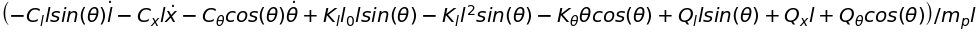

<IPython.core.display.Latex object>

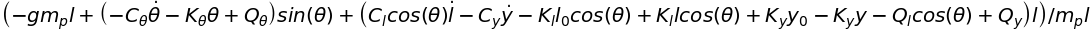

<IPython.core.display.Latex object>

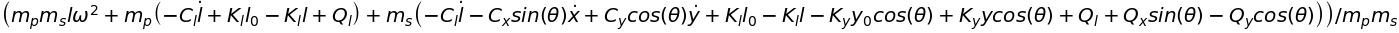

<IPython.core.display.Latex object>

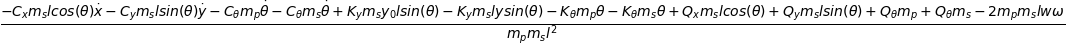

In [28]:
# Solve for the accelerations (derivatives of generalized speeds)
kane_solved = solve(fr + frstar, dsdt)

# Insert the equation from the eom_solved dictionary indexed using d2qdt2
kanes = Matrix([simplify(kane_solved[dsdt[k]]) for k in range(4)])

for k in range(4):
    # Display the equation
    display(Latex(dsdt[k]._repr_latex_() + '$\, = \,$'), kanes[k])  

In [29]:
# Verify the same result
display(simplify(kanes-eoms).subs(s[2], dqdt[2]).subs(s[3], dqdt[3]))

### Lagrange's Method
The built-in `LagrangesMethod` class can be easily initiated using the Lagrangian `L` and generalized force vector `q` that were defined earlier, which are the first two arguments when initializing the object. The optional keyword argument `forcelist` is used, which is created using the same procedure as the `loads` used in Kane's method, but omitting gravitational and spring forces which are included in the potential energy definition. When using the `forcelist` keyword argument, the additional `frame` keyword argument is also required, which provides the inertial reference frame `R`. Similar to prior methods, we can call the mass matrix and forcing vectors, and subtract the newly derived EOMs from the prior methods to compare and verify the same result.

In [30]:
# Build the list of forces acting on points, or moments acting on frames
force_list = [(player_cm, Fd[0] + Fi[0]),  # Forces on the player
              (stool_cm, Fd[1] + Fi[1]),   # Forces on the stool
              (R, Md[0] + Mi[0]),          # Moments on the player, R-frame
              (E, Md[1] + Mi[1])]          # Moments on the stool, E-frame

# Initialize the LagrangesMethod object
LM = LagrangesMethod(L, q, forcelist=force_list, frame=R)

# Call the internal method to calculate EOM
lagrange_eom = simplify(LM.form_lagranges_equations())
display(lagrange_eom)

# Display the mass matrix
display(Latex('$\mathbf{M} = \,$' + LM.mass_matrix._repr_latex_()))

# Display the forcing matrix
forcing = simplify(LM.forcing)
display(Latex('$\mathbf{F} = \, $' + forcing._repr_latex_()))

⎡                                                            2                
⎢                 Cₓ⋅ẋ - Qₓ + 1.0⋅mₚ⋅ẍ + 1.0⋅mₛ⋅l⋅sin(θ)⋅θ̇  - 1.0⋅mₛ⋅l⋅cos(
⎢                                                                             
⎢                                                                             
⎢C_y⋅ẏ - 1.0⋅K_y⋅(y₀ - y) - Q_y + g⋅(mₚ + mₛ) + 1.0⋅mₚ⋅ÿ - 1.0⋅mₛ⋅l⋅sin(θ)⋅θ
⎢                                                                             
⎢                                                                             
⎢              1.0⋅Cₗ⋅l̇ - 1.0⋅Kₗ⋅l₀ + 1.0⋅Kₗ⋅l - 1.0⋅Qₗ + 1.0⋅g⋅mₛ⋅cos(θ) - 1
⎢                                                                             
⎢                                                                      2      
⎣                   C_θ⋅θ̇ + 1.0⋅K_θ⋅θ - Q_θ - g⋅mₛ⋅l⋅sin(θ) + 1.0⋅mₛ⋅l ⋅θ̈ - 

                                                                            ⎤
θ)⋅θ̈ - 1.0⋅mₛ⋅sin(θ)⋅l̈ - 2.0⋅mₛ⋅cos(θ)⋅l̇⋅θ̇ + 1.0

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [31]:
# Verify same result as before
display(eom - lagrange_eom)  

An alternate approach to using the LagrangesMethod class is to use the built-in `Lagrangian` function to create the variable $L$. By default, the bodies (`player` and `stool`) have known kinetic energy as a function of the mass and velocities that were previously assigned. If we don't assign potential energy to the bodies, then calling the `Lagrangian` function yields $L=T$. In this case, the gravitational and spring forces can be brought into the equations using the `loads` list previously defined when applying Kane's method.

In [32]:
# Generate the Lagrangian, first argument is the reference frame, additional arguments are the bodies
L2 = Lagrangian(R, player, stool)

# Initialize the LagrangesMethod object using LG, using the loads list that includes gravity and springs
LM2 = LagrangesMethod(L2, q, forcelist=loads, frame=R)

# Call the internal method to calculate EOM
lagrange_eom2 = simplify(LM2.form_lagranges_equations())
display(lagrange_eom2)

⎡                                                   2                         
⎢                Cₓ⋅ẋ - Qₓ + mₚ⋅ẍ + mₛ⋅l⋅sin(θ)⋅θ̇  - mₛ⋅l⋅cos(θ)⋅θ̈ - mₛ⋅si
⎢                                                                             
⎢                                                                             
⎢C_y⋅ẏ - K_y⋅y₀ + K_y⋅y - Q_y + g⋅mₚ + g⋅mₛ + mₚ⋅ÿ - mₛ⋅l⋅sin(θ)⋅θ̈ - mₛ⋅l⋅c
⎢                                                                             
⎢                                                                     2       
⎢                    Cₗ⋅l̇ - Kₗ⋅l₀ + Kₗ⋅l - Qₗ + g⋅mₛ⋅cos(θ) - mₛ⋅l⋅θ̇  - mₛ⋅s
⎢                                                                             
⎢                                                           2                 
⎣                C_θ⋅θ̇ + K_θ⋅θ - Q_θ - g⋅mₛ⋅l⋅sin(θ) + mₛ⋅l ⋅θ̈ - mₛ⋅l⋅sin(θ)

                                                    ⎤
n(θ)⋅l̈ - 2⋅mₛ⋅cos(θ)⋅l̇⋅θ̇ + mₛ⋅ẍ                 ⎥
                      

In [33]:
# Verify same result as before
display(simplify(lagrange_eom2 - eom))

Finally, we may also define the player and stool potential energy manually. In this case, `force_list` should be of the reduced form where the graviational and spring force terms are removed.

In [34]:
# Define the player and stool potential energy
player.potential_energy = mp * grav * y + 0.5 * Ky * (y -  y0)**2
stool.potential_energy = ms * grav * (y + d + l * cos(th)) + 1/2 * Kl * (l - l0)**2 + 1/2 * Kt * th**2

# Generate the Lagrangian that includes potential energy
L3 = simplify(Lagrangian(R, player, stool))

# Initialize the LagrangesMethod object using LG, using the loads list that includes gravity and springs
LM3 = LagrangesMethod(L3, q, forcelist=force_list, frame=R)

# Call the internal method to calculate EOM
lagrange_eom3 = simplify(LM3.form_lagranges_equations())
display(lagrange_eom3)

⎡                                                                   2         
⎢                        Cₓ⋅ẋ - Qₓ + 1.0⋅mₚ⋅ẍ + 1.0⋅mₛ⋅l⋅sin(θ)⋅θ̇  - 1.0⋅mₛ
⎢                                                                             
⎢                                                                             
⎢C_y⋅ẏ - 1.0⋅K_y⋅y₀ + 1.0⋅K_y⋅y - Q_y + 1.0⋅g⋅mₚ + 1.0⋅g⋅mₛ + 1.0⋅mₚ⋅ÿ - 1.0
⎢                                                                             
⎢                                                                             
⎢                     1.0⋅Cₗ⋅l̇ - 1.0⋅Kₗ⋅l₀ + 1.0⋅Kₗ⋅l - 1.0⋅Qₗ + 1.0⋅g⋅mₛ⋅cos
⎢                                                                             
⎢                                                                             
⎣                        C_θ⋅θ̇ + 1.0⋅K_θ⋅θ - Q_θ - 1.0⋅g⋅mₛ⋅l⋅sin(θ) + 1.0⋅mₛ

                                                                              
⋅l⋅cos(θ)⋅θ̈ - 1.0⋅mₛ⋅sin(θ)⋅l̈ - 2.0⋅mₛ⋅cos(θ)⋅l̇⋅

In [35]:
# Verify same result as before
display(simplify(lagrange_eom3 - eom))

## Code Generation <a class="anchor" id="codegen"></a>
Next we substitute variables into the equation to create printed text that can be inserted into ordinary Python source code. The printed output represents the code to be implemented in a function of the form `du = f(u)`, where `u` is the list of state variables, and `du` are the derivatives of `u` with respect to time. Additionally, this code presumes the existence of a parameter object `p` containing the constants, and generalized force variables `Qx, Qy, Ql, Qth`.

This is done in two steps, first using the `.subs()` method which replaces symbolic variables in the equation, but returns an object of the symbolic data type. The second step is to change to a string data type, then use the `.replace()` method to swap in new strings that are shorter and/or more compatible with standard Python source code. It is worth noting that this entire operation could be using the second, string replacement method, but the symbolic substition is inclued for demonstration purposes.

The process begins by defining symbolic or string replacements. The symbols in `dq` are shortened form for the dynamic symbols previously created in the `dqdt`. Where the latter would print long strings intended for symbolic code (i.e. `Derivative(x(t), t)` which is typeset as $\frac{\partial}{\partial t} x(t)$), the replacement are 2 or 3 ascii characters (i.e. `dx`). 

The list `qstr` are simply the named set of state variables in the list `u`, which are included for readability of the string formatted EOM.

The string replacements are defined in `replist`, which is a $N\times 2$ list. In each row, the first entry (`replist[n][0]`) is the "old string", or expected pattern in the original string output, and the second entry (`replist[n][1]`) is the "new string", which replaces it.

In [36]:
# Define shortened symbols to replace using the subs command
dx, dy, dl, dth = symbols('dx dy dl dθ')
dq = Matrix([dx, dy, dl, dth]) 

# Define the variable names that are included in the list 'u'
qstr = 'x', 'y', 'l', 'th', 'dx', 'dy', 'dl', 'dth'

# Define the list of variables to replace in the string
replist = [['sin(θ(t))', 's'], ['cos(θ(t))', 'c'],
           ['x(t)', 'x'], ['y(t)', 'y'], ['l(t)', 'l'], ['θ(t)', 'th'], ['dθ', 'dth'],
           ['x_0', 'p.x0'], ['y_0', 'p.y0'], ['l_0', 'p.l0'],  
           ['m_p', 'p.mp'], ['m_s', 'p.ms'], ['g', 'p.g'],
           ['K_x', 'p.Kx'], ['K_y', 'p.Ky'], ['K_l', 'p.Kl'], ['K_θ', 'p.Kth'],
           ['C_x', 'p.Cx'], ['C_y', 'p.Cy'], ['C_l', 'p.Cl'], ['C_θ', 'p.Cth'], 
           ['Q_x', 'Qx'], ['Q_y', 'Qy'],['Q_l', 'Ql'], ['Q_θ', 'Qth']]

# Initialize the string formatted EOMs
eoms_print = ['du[4] = ', 'du[5] = ', 'du[6] = ', 'du[7] = ']

# Print string that unpacks the state variables
for k in range(4):
    print(qstr[k], '= u[' + str(k) + ']')
    print(' ')
    
# Print the shortened sine and cosine    
print('s = sin(th)')
print(' ')
print('c = cos(th)')
print(' ')    

# Print the velocity assignments
for k in range(4):
    print('du[' + str(k) + '] =', qstr[k+4], '= u[' + str(k+4) + ']')
    print(' ')
    
for k in range(4):
    # Load a copy of the eoms into the tmp_symbolic variable
    tmp_symbolic = eoms[k]
    
    # Replace the velocity terms with shortened variable
    # names (i.e. Derivative(x(t), t) replaced with dx)
    for j in range(4):
        tmp_symbolic = tmp_symbolic.subs(dqdt[j], dq[j])
    
    # Create a temporary string formatted equation
    tmp_string = str(tmp_symbolic)
    
    # Replace old_string with new_string from the replist
    for old_string, new_string in replist:
        tmp_string = tmp_string.replace(old_string, new_string)

    # Replace the print string with tmp, and print result
    eoms_print[k] += tmp_string
    print(eoms_print[k])
    print(' ')

x = u[0]
 
y = u[1]
 
l = u[2]
 
th = u[3]
 
s = sin(th)
 
c = cos(th)
 
du[0] = dx = u[4]
 
du[1] = dy = u[5]
 
du[2] = dl = u[6]
 
du[3] = dth = u[7]
 
du[4] = (-p.Cl*dl*l*s - p.Cx*dx*l - p.Cth*dth*c + p.Kl*p.l0*l*s - p.Kl*l**2*s - p.Kth*th*c + Ql*l*s + Qx*l + Qth*c)/(p.mp*l)
 
du[5] = (-p.g*p.mp*l + (-p.Cth*dth - p.Kth*th + Qth)*s + (p.Cl*dl*c - p.Cy*dy - p.Kl*p.l0*c + p.Kl*l*c + p.Ky*p.y0 - p.Ky*y - Ql*c + Qy)*l)/(p.mp*l)
 
du[6] = (dth**2*p.mp*p.ms*l + p.mp*(-p.Cl*dl + p.Kl*p.l0 - p.Kl*l + Ql) + p.ms*(-p.Cl*dl - p.Cx*dx*s + p.Cy*dy*c + p.Kl*p.l0 - p.Kl*l - p.Ky*p.y0*c + p.Ky*y*c + Ql + Qx*s - Qy*c))/(p.mp*p.ms)
 
du[7] = (-p.Cx*dx*p.ms*l*c - p.Cy*dy*p.ms*l*s - p.Cth*dth*p.mp - p.Cth*dth*p.ms + p.Ky*p.ms*p.y0*l*s - p.Ky*p.ms*l*y*s - p.Kth*p.mp*th - p.Kth*p.ms*th + Qx*p.ms*l*c + Qy*p.ms*l*s + Qth*p.mp + Qth*p.ms - 2.0*dl*dth*p.mp*p.ms*l)/(p.mp*p.ms*l**2)
 
